# Tugas Time Series Analisa Kualitas Udara
## Mengumpulkan data dan dijadikan CSV

Kita ambil data dari openeo, dengan fokus di area Bangkalan berdasarkan koordinat rata-rata hasil poligon yang telah di ambil dengan output "no2_bangkalan.nc"

In [11]:
import openeo
from shapely.geometry import shape
import pandas as pd
import matplotlib.pyplot as plt
import os

# Koneksi & autentikasi ke Copernicus Data Space Ecosystem
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# Definisi area Bangkalan (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [112.73853929664097, -7.023628073721952],
            [112.73853929664097, -7.05158377585353],
            [112.7680283135615, -7.05158377585353],
            [112.7680283135615, -7.023628073721952],
            [112.73853929664097, -7.023628073721952],
        ]
    ],
}

# Memuat koleksi data Sentinel-5P (NO2) dari Copernicus
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2024-10-24", "2025-10-24"],   # rentang waktu pengambilan data
    spatial_extent={
        "west": 112.73853929664097,
        "south": -7.05158377585353,
        "east": 112.7680283135615,
        "north": -7.023628073721952
    },
    bands=["NO2"],   # variabel polutan yang diambil
)

def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# Definisikan area sebagai FeatureCollection (untuk agregasi spasial)
feature = {"type": "Feature", "geometry": aoi, "properties": {"id": 1}}
fc = {"type": "FeatureCollection", "features": [feature]}

job = daily_mean_aoi.execute_batch(out_format="CSV")

results = job.get_results()
results.download_files("data-copernicus")

for f in os.listdir("data-copernicus"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("data-copernicus", f))
        print("File ditemukan:", f)
        break

df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()


Authenticated using refresh token.
0:00:00 Job 'j-251102215940423984498504b827bd88': send 'start'
0:00:14 Job 'j-251102215940423984498504b827bd88': created (progress 0%)
0:00:19 Job 'j-251102215940423984498504b827bd88': created (progress 0%)
0:00:26 Job 'j-251102215940423984498504b827bd88': created (progress 0%)
0:00:34 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:00:44 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:00:56 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:01:12 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:01:31 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:01:55 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:02:25 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:03:04 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:03:51 Job 'j-251102215940423984498504b827bd88': running (progress N/A)
0:04:49 Job 'j-25110221594042

/tmp/ipykernel_2121/355476302.py:63: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


In [12]:
new_df = pd.read_csv('data-copernicus/timeseries.csv')
new_df = new_df.sort_values(by='date').reset_index(drop=True)
new_df['date'] = pd.to_datetime(new_df['date']).dt.date
new_df

,date,feature_index,NO2
0,2024-10-23,0,NaN
1,2024-10-24,0,NaN
2,2024-10-25,0,NaN
3,2024-10-26,0,0.000020
4,2024-10-27,0,0.000039
...,...,...,...
361,2025-10-19,0,0.000030
362,2025-10-20,0,NaN
363,2025-10-21,0,NaN
364,2025-10-22,0,NaN


In [ ]:
print("\nInformasi Dataset:")
print(df.info())


📊 Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           366 non-null    datetime64[ns, UTC]
 1   feature_index  366 non-null    int64              
 2   NO2            106 non-null    float64            
 3   month          366 non-null    period[M]          
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), period[M](1)
memory usage: 11.6 KB
None


## Pre-processing

Penanganan missing values menggunakan interpolasi

In [18]:
print("\nCek Missing Value:")
print(df.isnull().sum())


Cek Missing Value:
date               0
feature_index      0
NO2              260
month              0
dtype: int64


Terlihat hasil data nya disni memili missing values, ini tanda nya satelit di sentinel_5p tidak dapat membaca data pada hari tersbut dikarenakan sensor tersbut tidak selalu melewati bangkalan setiap hari dengan awan yang bersih atau di bawah ambang batas, maka dari itu kita perlu menangani nya penuh dengan menggunakan interpolasi

In [19]:
new_df = pd.Series(new_df['NO2'].values, index=new_df['date'], name='NO2')
new_df = new_df.interpolate(method='linear').bfill()
new_df = pd.DataFrame(new_df).reset_index()
new_df.to_csv("data-copernicus/timeseries.csv")
new_df.head(5)

,date,NO2
0,2024-10-23,0.000020
1,2024-10-24,0.000020
2,2024-10-25,0.000020
3,2024-10-26,0.000020
4,2024-10-27,0.000039


In [20]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(new_df)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

,Missing Count,Missing Percent (%)
date,0,0.0
NO2,0,0.0


## Membentuk Data Supervised

Pada tahap ini akan di bentuk data supervised supaya bisa di proses di knn nanti, dimana nanti fitur fitur nya adalah NO2 yang sebelumnya dan tagetnya adalah NO2 saat ini, artinya kita akan memprediksi NO2 saat ini berdasarkan NO2 sebelumnya

inisialisasi hari ke 2-5

In [21]:
h2 = new_df
h3 = new_df
h4 = new_df
h5 = new_df

data h1&2

In [23]:
h2 = h2.drop(columns=['date'])
hari = 2

for i in range(1, hari + 1):
    names = f"h{i}"
    h2[names] = h2['NO2'].shift(i)

h2 = h2.dropna().reset_index(drop=True)
h2

,NO2,h1,h2
0,0.000020,0.000020,0.000020
1,0.000020,0.000020,0.000020
2,0.000039,0.000020,0.000020
3,0.000042,0.000039,0.000020
4,0.000041,0.000042,0.000039
...,...,...,...
359,0.000030,0.000032,0.000034
360,0.000030,0.000030,0.000032
361,0.000030,0.000030,0.000030
362,0.000030,0.000030,0.000030


data h1,h2&h3

In [24]:
h3 = h3.drop(columns=['date'])
hari = 3

for i in range(1, hari + 1):
    names = f"h{i}"
    h3[names] = h3['NO2'].shift(i)

h3 = h3.dropna().reset_index(drop=True)
h3

,NO2,h1,h2,h3
0,0.000020,0.000020,0.000020,0.000020
1,0.000039,0.000020,0.000020,0.000020
2,0.000042,0.000039,0.000020,0.000020
3,0.000041,0.000042,0.000039,0.000020
4,0.000040,0.000041,0.000042,0.000039
...,...,...,...,...
358,0.000030,0.000032,0.000034,0.000037
359,0.000030,0.000030,0.000032,0.000034
360,0.000030,0.000030,0.000030,0.000032
361,0.000030,0.000030,0.000030,0.000030


data h1,h2,h3&h4

In [25]:
h4 = h4.drop(columns=['date'])
hari = 4

for i in range(1, hari + 1):
    names = f"h{i}"
    h4[names] = h4['NO2'].shift(i)

h4 = h4.dropna().reset_index(drop=True)
h4

,NO2,h1,h2,h3,h4
0,0.000039,0.000020,0.000020,0.000020,0.000020
1,0.000042,0.000039,0.000020,0.000020,0.000020
2,0.000041,0.000042,0.000039,0.000020,0.000020
3,0.000040,0.000041,0.000042,0.000039,0.000020
4,0.000039,0.000040,0.000041,0.000042,0.000039
...,...,...,...,...,...
357,0.000030,0.000032,0.000034,0.000037,0.000039
358,0.000030,0.000030,0.000032,0.000034,0.000037
359,0.000030,0.000030,0.000030,0.000032,0.000034
360,0.000030,0.000030,0.000030,0.000030,0.000032


data h1,h2,h3,h4&h5

In [26]:
h5 = h5.drop(columns=['date'])
hari = 5

for i in range(1, hari + 1):
    names = f"h{i}"
    h5[names] = h5['NO2'].shift(i)

h5 = h5.dropna().reset_index(drop=True)
h5

,NO2,h1,h2,h3,h4,h5
0,0.000042,0.000039,0.000020,0.000020,0.000020,0.000020
1,0.000041,0.000042,0.000039,0.000020,0.000020,0.000020
2,0.000040,0.000041,0.000042,0.000039,0.000020,0.000020
3,0.000039,0.000040,0.000041,0.000042,0.000039,0.000020
4,0.000023,0.000039,0.000040,0.000041,0.000042,0.000039
...,...,...,...,...,...,...
356,0.000030,0.000032,0.000034,0.000037,0.000039,0.000041
357,0.000030,0.000030,0.000032,0.000034,0.000037,0.000039
358,0.000030,0.000030,0.000030,0.000032,0.000034,0.000037
359,0.000030,0.000030,0.000030,0.000030,0.000032,0.000034


## Model KNN Regression

In [27]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Menghitung Mean Absolute Percentage Error (MAPE).
    Menghindari pembagian dengan nol.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Menghindari pembagian dengan nol (jika y_true ada yang 0)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan # Tidak ada data valid untuk dihitung

    # Hitung MAPE hanya pada data yang y_true-nya bukan 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    return mape

In [28]:
list_scores = []

Pada tahap ini akan dilakukan split data dan normalisasi data sehingga pada saat pemodelan menggunakan metode KNN Regression dapat di proses dengan lebih baik

data h1&h2

In [29]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


X = h2.drop(columns=['NO2'])
y = h2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
h2_predict = knn.predict(X_test_scaled)
r2_h2 = r2_score(y_test, h2_predict)
mse_h2 = mean_squared_error(y_test, h2_predict)

print("MSE:", mse_h2)
print("R2:", r2_h2)

MSE: 7.60617857503948e-11
R2: 0.5074232548908713


mape 2 lag

In [35]:
# --- Modelling Data h1 dan h2 ---
X = h2.drop(columns=['NO2'])
y = h2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_h2 = MinMaxScaler()
X_train_scaled = scaler_h2.fit_transform(X_train)
X_test_scaled = scaler_h2.transform(X_test)

knn_h2 = KNeighborsRegressor(n_neighbors=5)
knn_h2.fit(X_train_scaled, y_train)
h2_predict = knn_h2.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h2 = mean_absolute_percentage_error(y_test, h2_predict)
print(f"MAPE h2: {mape_h2:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h2',  # <-- Label yang benar
    'MAPE': mape_h2
}
list_scores.append(scores)

MAPE h2: 100.41 %


data h1,h2&h3

In [37]:
X = h3.drop(columns=['NO2'])
y = h3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h3_predict = knn.predict(X_test_scaled)
r2_h3 = r2_score(y_test, h3_predict)
mse_h3 = mean_squared_error(y_test, h3_predict)

print("MSE:", mse_h3)
print("R²:", r2_h3)

MSE: 7.982078521946408e-11
R²: 0.3927664540043483


mape 3 lag

In [36]:
# --- Modelling Data h1 dan h3 ---
X = h3.drop(columns=['NO2'])
y = h3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_h3 = MinMaxScaler()
X_train_scaled = scaler_h3.fit_transform(X_train)
X_test_scaled = scaler_h3.transform(X_test)

knn_h3 = KNeighborsRegressor(n_neighbors=7)
knn_h3.fit(X_train_scaled, y_train)
h3_predict = knn_h3.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h3 = mean_absolute_percentage_error(y_test, h3_predict)
print(f"MAPE h3: {mape_h3:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h3',  # <-- Label yang benar
    'MAPE': mape_h3
}
list_scores.append(scores)

MAPE h3: 66.60 %


data h1,h2,h3&h4

In [38]:
X = h4.drop(columns=['NO2'])
y = h4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h4_predict = knn.predict(X_test_scaled)
r2_h4 = r2_score(y_test, h4_predict)
mse_h4 = mean_squared_error(y_test, h4_predict)

print("MSE:", mse_h4)
print("R²:", r2_h4)

MSE: 9.216447688373713e-11
R²: 0.1741502876221117


mape 4 lag

In [39]:
# --- Modelling Data h1 dan h4 ---
X = h4.drop(columns=['NO2'])
y = h4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_h4 = MinMaxScaler()
X_train_scaled = scaler_h4.fit_transform(X_train)
X_test_scaled = scaler_h4.transform(X_test)

knn_h4 = KNeighborsRegressor(n_neighbors=7)
knn_h4.fit(X_train_scaled, y_train)
h4_predict = knn_h4.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h4 = mean_absolute_percentage_error(y_test, h4_predict)
print(f"MAPE h4: {mape_h4:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h4',  # <-- Label yang benar
    'MAPE': mape_h4
}
list_scores.append(scores)

MAPE h4: 24.91 %


data h1,h2,h3,h4&h5

In [40]:
X = h5.drop(columns=['NO2'])
y = h5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h5_predict = knn.predict(X_test_scaled)
r2_h5 = r2_score(y_test, h5_predict)
mse_h5 = mean_squared_error(y_test, h5_predict)

print("MSE:", mse_h5)
print("R²:", r2_h5)

MSE: 6.841688552687896e-11
R²: 0.206890529478731


mape 5 lag

In [41]:
# --- Modelling Data h1 dan h5 ---
X = h5.drop(columns=['NO2'])
y = h5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_h5 = MinMaxScaler()
X_train_scaled = scaler_h5.fit_transform(X_train)
X_test_scaled = scaler_h5.transform(X_test)

knn_h5 = KNeighborsRegressor(n_neighbors=7)
knn_h5.fit(X_train_scaled, y_train)
h5_predict = knn_h5.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h5 = mean_absolute_percentage_error(y_test, h5_predict)
print(f"MAPE h5: {mape_h5:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h5',  # <-- Label yang benar
    'MAPE': mape_h5
}
list_scores.append(scores)

MAPE h5: 80.67 %


perbandingan nilai dengan r2

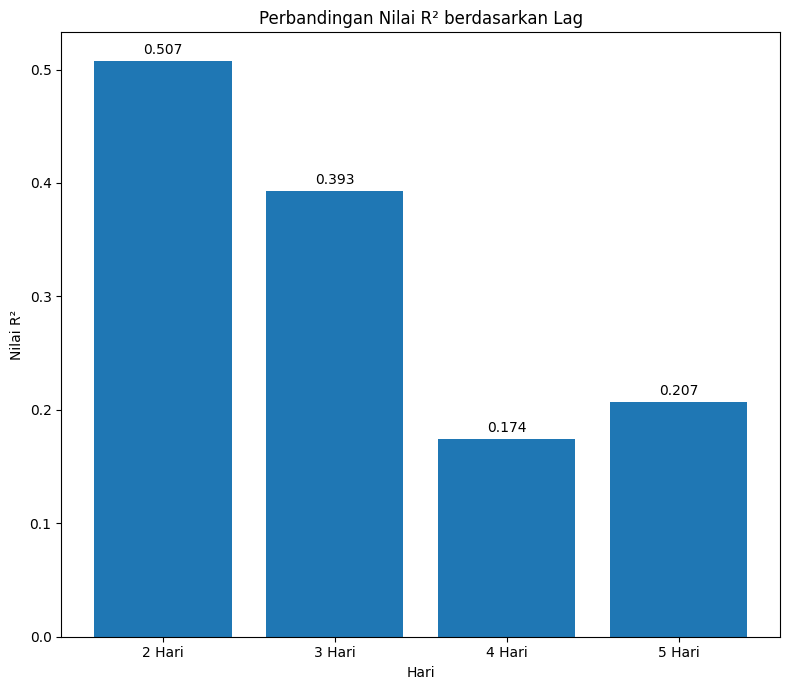

In [42]:
x = ['2 Hari', '3 Hari', '4 Hari', '5 Hari']
y = [r2_h2, r2_h3, r2_h4, r2_h5]
knn = KNeighborsRegressor(n_neighbors=2)

fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(x, y)

ax.set_title("Perbandingan Nilai R² berdasarkan Lag")
ax.set_xlabel("Hari")
ax.set_ylabel("Nilai R²")

ax.bar_label(bars, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

### Uji Coba Beberapa Jumlah Lag

perbandngan mape dengan beberapa lag


Data yang Digunakan untuk Chart (Urutan Eksekusi):
| Lag   |     MAPE |
|:------|---------:|
| h1-h2 | 111.8458 |
| h1-h2 | 100.4146 |
| h1-h2 | 104.5694 |
| h1-h2 | 113.3356 |
| h1-h2 | 103.2203 |
| h1-h2 | 100.4146 |
| h1-h3 |  66.5956 |
| h1-h4 |  24.9056 |
| h1-h5 |  80.6651 |


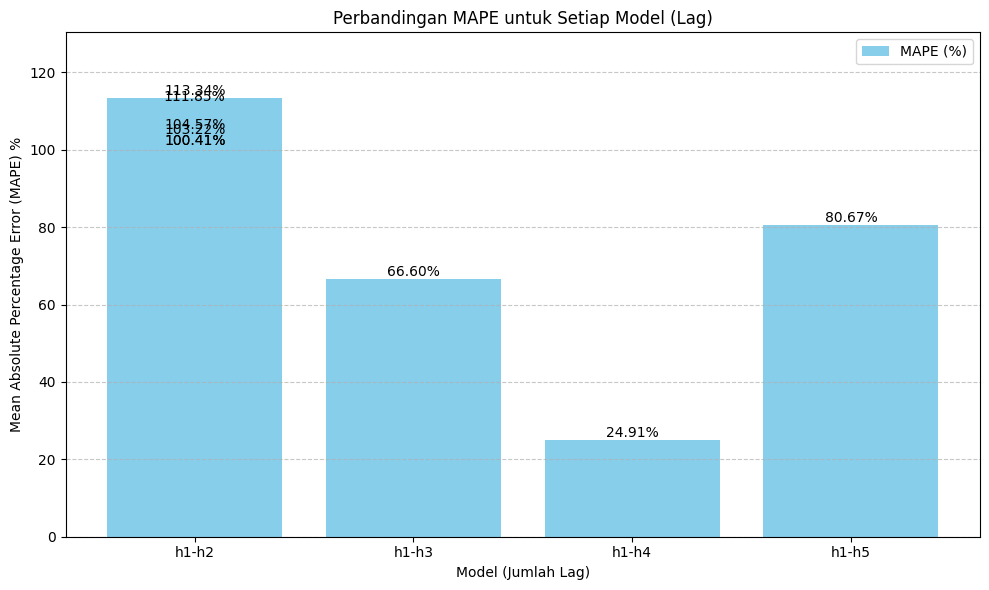

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

try:
    # Mengubah list of dictionaries menjadi DataFrame
    scores_df = pd.DataFrame(list_scores)

    # --- Membuat Bar Chart ---
    plt.figure(figsize=(10, 6))

    # Gunakan 'scores_df' (bukan scores_df_sorted) untuk plotting
    bars = plt.bar(scores_df['Lag'], scores_df['MAPE'], color='skyblue', label='MAPE (%)')

    # Menambahkan label nilai di atas setiap bar
    for bar in bars:
        yval = bar.get_height()
        # Menampilkan nilai MAPE dengan 2 angka desimal
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center')

    plt.title('Perbandingan MAPE untuk Setiap Model (Lag)')
    plt.xlabel('Model (Jumlah Lag)')
    plt.ylabel('Mean Absolute Percentage Error (MAPE) %')

    # Atur batas Y (menggunakan scores_df)
    if not scores_df.empty:
        plt.ylim(0, max(scores_df['MAPE']) * 1.15)
    else:
        plt.ylim(0, 10) # Batas default jika data kosong

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()


    # Menampilkan tabel data (menggunakan scores_df)
    print("\nData yang Digunakan untuk Chart (Urutan Eksekusi):")
    print(scores_df.to_markdown(index=False, floatfmt=".4f"))

    plt.show() # <-- Menampilkan chart

except NameError:
    print("--- ERROR ---")
    print("Variabel 'list_scores' belum terdefinisi.")
    print("Pastikan Anda sudah menjalankan cell-cell modelling (h2, h3, h4, h5) sebelumnya.")
except Exception as e:
    print(f"Terjadi error: {e}")
    print("Pastikan 'list_scores' Anda berisi data yang valid.")

output untuk hari berikutnya

In [45]:
# 1. Ambil 3 nilai NO2 terakhir
last_3_values = new_df['NO2'].values[-3:]
print(f"Data input (3 hari terakhir)")

# 2. TENTUKAN NAMA FITUR (sesuai dengan model h1-h3)
#    (Ini adalah kolom X dari cell modelling h3 Anda)
feature_names = ['h1', 'h2', 'h3']

# 3. Ubah input menjadi DataFrame DENGAN NAMA FITUR
input_df = pd.DataFrame([last_3_values], columns=feature_names)

# 4. Scale data input menggunakan scaler yang sesuai (scaler_h3)
try:
    # Sekarang scaler akan melihat nama kolom dan tidak akan warning
    input_data_scaled = scaler_h3.transform(input_df)

    # 5. Buat prediksi menggunakan model terbaik Anda (knn_h3)
    predicted_no2 = knn_h3.predict(input_data_scaled)

    print("\n--- HASIL PREDIKSI ---")
    print(f"Prediksi konsentrasi NO2 untuk hari berikutnya adalah: {predicted_no2[0]:.8f}")

except NameError as e:
    print(f"\n--- ERROR ---")
    print(f"Error: {e}. Pastikan variabel 'scaler_h3' dan 'knn_h3' sudah terdefinisi")
    print("dari cell modelling h1-h3 Anda.")
except Exception as e:
    print(f"\nTerjadi error lain: {e}")

Data input (3 hari terakhir)

--- HASIL PREDIKSI ---
Prediksi konsentrasi NO2 untuk hari berikutnya adalah: 0.00003028


cek kadar no2 apakah baik atau tidak

In [46]:
try:
    pred_value = predicted_no2[0]

    # 1. Hitung ambang batas statistik dari data historis Anda (new_df)

    # Median (50% data berada di bawah nilai ini)
    median_val = new_df['NO2'].quantile(0.50)

    # Kuantil Atas (75% data berada di bawah nilai ini)
    upper_quantile_val = new_df['NO2'].quantile(0.75)

    print(f"Nilai Prediksi \t\t: {pred_value:.8f} mol/m^2")
    print(f"Median Historis (Batas 'Baik')\t: {median_val:.8f} mol/m^2")
    print(f"Kuantil Atas (Batas 'Sedang')\t: {upper_quantile_val:.8f} mol/m^2")

    # 2. Buat kategori berdasarkan perbandingan
    if pred_value <= median_val:
        kategori = "Baik"
        penjelasan = f"Nilai ini berada di bawah atau sama dengan batas baik."
    elif pred_value <= upper_quantile_val:
        kategori = "Sedang"
        penjelasan = f"Nilai ini di atas median, tapi di bawah kuantil atas ({upper_quantile_val:.8f})."
    else:
        kategori = "Tinggi (Tidak Baik)"
        penjelasan = f"Nilai ini berada di atas 75% dari data historis Anda (lebih tinggi dari {upper_quantile_val:.8f})."

    print("\n-------------------------------------------------")
    print(f"Kategori Prediksi : **{kategori}**")
    print(f"Penjelasan: {penjelasan}")
    print("-------------------------------------------------")

except NameError:
    print("Error: Pastikan variabel 'predicted_no2' dan 'new_df' sudah ada.")
except Exception as e:
    print(f"Terjadi error: {e}")

Nilai Prediksi 		: 0.00003028 mol/m^2
Median Historis (Batas 'Baik')	: 0.00002477 mol/m^2
Kuantil Atas (Batas 'Sedang')	: 0.00003230 mol/m^2

-------------------------------------------------
Kategori Prediksi : **Sedang**
Penjelasan: Nilai ini di atas median, tapi di bawah kuantil atas (0.00003230).
-------------------------------------------------


# Deployment

Pada tahap ini akan di deploy menggunakan gardio dan di upload di hugging face secara online

In [47]:
import joblib

# Simpan model dan scaler ke file
joblib.dump(knn_h3, "model_h3.pkl")
joblib.dump(scaler_h3, "scaler_h3.pkl")

# Simpan dataset hasil olahan (new_df)
new_df.to_csv("data_no2.csv", index=False)

print("File berhasil disimpan:")
print("- model_h3.pkl")
print("- scaler_h3.pkl")
print("- data_no2.csv")

File berhasil disimpan:
- model_h3.pkl
- scaler_h3.pkl
- data_no2.csv


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import timedelta

# ===============================
# Path File
# ===============================
MODEL_PATH = "model_h3.pkl"
SCALER_PATH = "scaler_h3.pkl"
DATA_PATH = "data_no2.csv"

# ===============================
# Load Model & Data
# ===============================
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

try:
    df = pd.read_csv(DATA_PATH, parse_dates=['date'])
    df = df.sort_values('date').reset_index(drop=True)

    if 'NO2' not in df.columns:
        raise ValueError("Kolom 'NO2' tidak ditemukan dalam dataset.")

    # Buat fitur lag 3 hari
    df['h1'] = df['NO2'].shift(1)
    df['h2'] = df['NO2'].shift(2)
    df['h3'] = df['NO2'].shift(3)
    df = df.dropna().reset_index(drop=True)

except Exception as e:
    df = None
    print(f"⚠️ Gagal memuat data historis: {e}")

# ===============================
# Fungsi Kategori WHO
# ===============================
def kategori_no2(value):
    if value < 0.000020:
        return "🟢 Baik"
    elif value < 0.000040:
        return "🟡 Sedang ⚠️"
    elif value < 0.000060:
        return "🟠 Tidak Sehat 🚫"
    else:
        return "🔴 Sangat Tidak Sehat ☠️"

# ===============================
# MODE 1: Prediksi Otomatis
# ===============================
def prediksi_otomatis():
    if df is None or df.empty:
        return "❌ Data historis tidak ditemukan atau kosong.", None

    last_row = df.iloc[-1]
    next_day = last_row['date'] + timedelta(days=1)

    # Ambil 3 hari terakhir sebagai input fitur
    last_features = pd.DataFrame([[last_row['h1'], last_row['h2'], last_row['h3']]],
                                 columns=['h1', 'h2', 'h3'])
    last_scaled = scaler.transform(last_features)
    pred = model.predict(last_scaled)[0]
    kategori = kategori_no2(pred)

    # Buat plot historis
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(df['date'], df['NO2'], marker='o', label='Data Historis')
    ax.scatter(next_day, pred, color='red', s=80, label='Prediksi Hari Berikutnya')
    ax.set_title("Prediksi Otomatis Konsentrasi NO₂")
    ax.set_xlabel("Tanggal")
    ax.set_ylabel("Konsentrasi NO₂ (mol/m²)")
    ax.legend()
    plt.tight_layout()

    hasil = (
        f"**Tanggal Prediksi:** {next_day.strftime('%Y-%m-%d')}  \n"
        f"**Perkiraan Konsentrasi NO₂:** {pred:.6f} mol/m²  \n"
        f"**Kategori Udara (WHO):** {kategori}"
    )

    return hasil, fig

# ===============================
# MODE 2: Prediksi Manual Interaktif
# ===============================
def prediksi_manual(h1, h2, h3):
    try:
        features = pd.DataFrame([[h1, h2, h3]], columns=['h1', 'h2', 'h3'])
        scaled = scaler.transform(features)
        pred = model.predict(scaled)[0]
        kategori = kategori_no2(pred)
        hasil = (
            f"**Perkiraan Konsentrasi NO₂:** {pred:.6f} mol/m²  \n"
            f"**Kategori Udara (WHO):** {kategori}"
        )
        return hasil
    except Exception as e:
        return f"Terjadi kesalahan saat prediksi: {e}"

# ===============================
# Tampilan Gradio
# ===============================
with gr.Blocks(theme=gr.themes.Soft()) as app:
    gr.Markdown("## 🌫️ Aplikasi Prediksi Konsentrasi NO₂ (Sidayu, Gresik)")
    gr.Markdown("Gunakan aplikasi ini untuk memprediksi kadar NO₂ harian berdasarkan model pembelajaran mesin.")

    with gr.Tab("🔮 Prediksi Otomatis"):
        gr.Markdown("Aplikasi akan mengambil data 3 hari terakhir dari dataset untuk memprediksi hari berikutnya.")
        tombol_pred = gr.Button("Jalankan Prediksi Otomatis")
        output_text = gr.Markdown()
        output_plot = gr.Plot()
        tombol_pred.click(fn=prediksi_otomatis, inputs=None, outputs=[output_text, output_plot])

    with gr.Tab("🧮 Prediksi Manual Interaktif"):
        gr.Markdown("Masukkan nilai konsentrasi NO₂ dari 3 hari terakhir (satuan: mol/m²):")
        with gr.Row():
            h1 = gr.Number(label="Hari ke-1 (H-1)", value=0.000035)
            h2 = gr.Number(label="Hari ke-2 (H-2)", value=0.000040)
            h3 = gr.Number(label="Hari ke-3 (H-3)", value=0.000045)
        hasil_manual = gr.Markdown()
        tombol_manual = gr.Button("Prediksi Sekarang")
        tombol_manual.click(fn=prediksi_manual, inputs=[h1, h2, h3], outputs=hasil_manual)

app.launch()